In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EURUSDX.csv')
df = df.dropna()
df=df.reset_index()['Close']


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2* len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 47ms/step - loss: 0.0924 - val_loss: 0.1053
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0150 - val_loss: 0.0720
Epoch 3/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0095 - val_loss: 0.0387
Epoch 4/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0064 - val_loss: 0.0197
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 6/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0018 - val_loss: 0.0152
Epoch 7/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0141
Epoch 8/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 9/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 10/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 0.0043

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# Chia train test lại
train_data1 = df[:train_size]
test_data1 = df[train_size:train_size+test_size]
val_data1 = df[train_size+test_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 0.028761623389001265
Testing RMSE: 0.08062687815942682
Validation MAPE: 2.200259467452695
Testing MAPE: 6.106285940372134
Validation MAE: 0.023419779514269688
Testing MAE: 0.06640612164153063


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[45:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.40703666]
101
1 day input [0.43863382 0.44339046 0.45502124 0.44554571 0.43766259 0.43053449
 0.43405564 0.48618652 0.44921787 0.4100013  0.38937546 0.38902197
 0.38424817 0.39333246 0.37116912 0.38925877 0.39107769 0.37599097
 0.36706797 0.3734788  0.37285419 0.36234908 0.34649017 0.34383044
 0.32897365 0.34834684 0.33671263 0.36815932 0.344407   0.35349129
 0.37481382 0.32759745 0.32717876 0.33924882 0.37320768 0.3874021
 0.38831156 0.33878551 0.34934896 0.37156379 0.385391   0.40429745
 0.43729537 0.42517039 0.40565306 0.41556445 0.42670103 0.42811155
 0.44905313 0.41428434 0.45166826 0.46808657 0.44860355 0.45436575
 0.45211784 0.43693159 0.45346658 0.48173875 0.50051822 0.47717773
 0.45616751 0.47332711 0.46536505 0.47179991 0.47912362 0.50219643
 0.47436012 0.49800262 0.49277581 0.48552073 0.47121991 0.48552073
 0.50543273 0.48964589 0.48818733 0.48045178 0.46965152 0.47630602
 0.45162707 0.4312243  0.43843134 0.43567551 0.4262995  0.40469555
 0.4209457  0.41693035 0.40274279 

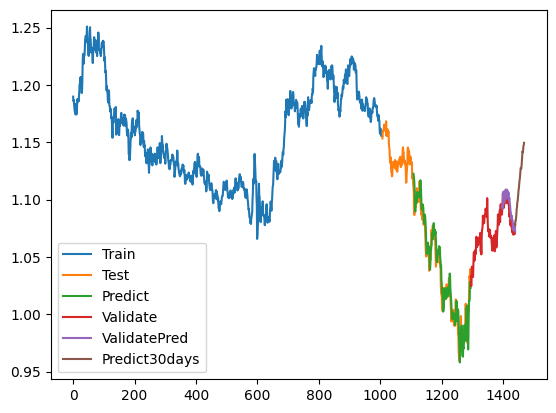

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()